In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm import tqdm
from shapely.geometry import box, Polygon
from shapely.ops import transform
from shapely import wkt
import matplotlib.pyplot as plt
import os, sys
import pyproj
from src.satellite_images.storage import SentinelDataset

#Enables imports from src directory in notebooks
sys.path.insert(0, os.path.abspath('../src'))
sys.path.insert(0, os.path.abspath('../src/data_handling'))
#Auto update imports when python files in src is updated
%load_ext autoreload
%autoreload 2

from satellite_images import read_sat_images_file
from utils import boundingBox, write_polygons_to_shp, plot_polygons, png_to_geotiff


data_location = "../../kornmo-data-files/raw-data"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def get_farmer_centroid(nrows=None):
    farmer_centroid = pd.read_csv(os.path.join(data_location, 'farm-information/centroid_coordinates_new.csv'), delimiter=',', nrows=nrows)
    columns_to_keep = ['orgnr', 'latitude', 'longitude', 'kommunenr']
    farmer_centroid = farmer_centroid.filter(columns_to_keep)
    farmer_centroid = farmer_centroid.dropna()
    farmer_centroid['orgnr'] = farmer_centroid['orgnr'].astype(str)
    farmer_centroid['latitude'] = farmer_centroid['latitude'].astype(float)
    farmer_centroid['longitude'] = farmer_centroid['longitude'].astype(float)
    farmer_centroid['kommunenr'] = farmer_centroid['kommunenr'].astype(int)
    return farmer_centroid

def get_polygon_data(nrows=None):
    
    soilquality = pd.read_csv(os.path.join(data_location, 'soil-data/jordsmonn_geometry.csv'), dtype=str, nrows=nrows)
    soilquality = soilquality.dropna()
    soilquality['geometry'] = soilquality['geometry'].apply(wkt.loads)
    geo_soilquality = gpd.GeoDataFrame(soilquality, crs='epsg:4326')
    geo_soilquality['municipal_nr'] = geo_soilquality['municipal_nr'].astype(int)
    
    return geo_soilquality

def get_disp_eiendommer():
    disp_eien = gpd.read_file(os.path.join(data_location, 'farm-information/farm-properties/disposed-properties-previous-students/disponerte_eiendommer.gpkg'), layer='disponerte_eiendommer')
    disp_eien = disp_eien.dropna()
    disp_eien.drop_duplicates(['orgnr', 'geometry'], keep='first', inplace=True)
    disp_eien['orgnr'] = disp_eien['orgnr'].astype(str)

    return disp_eien

def get_combined_satellite_data():
    sat_images0 = read_sat_images_file('sentinel_100x100_0.h5')
    sat_images1 = read_sat_images_file('sentinel_100x100_1.h5')
    in_first = set(sat_images0)
    in_second = set(sat_images1)

    in_second_but_not_in_first = in_second - in_first

    result = list(sat_images0) + list(in_second_but_not_in_first)

    return result


def filter_by_municipal(dataframe, municipal_nr):
    return dataframe.loc[dataframe['municipal_nr'] == municipal_nr]


def get_polygons_by_municipal(dataframe, municipal_nr):
    polygons_by_muni = dataframe.loc[dataframe['municipal_nr'] == municipal_nr]
    polygons_list = polygons_by_muni['geometry'].tolist()
    return polygons_list

def convert_crs(polygons):
    project = pyproj.Transformer.from_proj(pyproj.Proj('epsg:25833'), pyproj.Proj('epsg:4326'), always_xy=True)
    return [transform(project.transform, poly) for poly in polygons]



In [5]:
print("Retrieving data")
disp_eien = get_disp_eiendommer()
field_data = get_polygon_data()
farmer_centroid = get_farmer_centroid()

sat_orgnr = np.array(get_combined_satellite_data())


Retrieving data


100%|██████████| 3477/3477 [00:31<00:00, 111.96it/s]


In [6]:
farm_orgnr = np.array(list(disp_eien['orgnr']))
intersection = np.intersect1d(sat_orgnr, farm_orgnr)

filtered_disp_eien = disp_eien[disp_eien['orgnr'].isin(intersection)]
filtered_satellite_data = intersection[:]

print(f"Amount of fields from disposed properties: {filtered_disp_eien.shape}")
print(f"Amount of organisation numbers from satellite data: {len(filtered_satellite_data)}")
print(f"Amount of fields from jordsmonn: {field_data.shape}")



municipal_nrs = []
idxs_to_remove = []
orgnrs_to_check = list(set(farmer_centroid['orgnr'].tolist()))
for index, row in tqdm(filtered_disp_eien.iterrows(), total=filtered_disp_eien.shape[0]):
    if row['orgnr'] in orgnrs_to_check:
        municipal_nrs.append(farmer_centroid.loc[farmer_centroid['orgnr'] == row['orgnr']]['kommunenr'].iloc[0])
    else:
        idxs_to_remove.append(index)
    
filtered_disp_eien = filtered_disp_eien.drop(idxs_to_remove)



Amount of fields from disposed properties: (8442, 3)
Amount of organisation numbers from satellite data: 6890
Amount of fields from jordsmonn: (629040, 4)


100%|██████████| 8442/8442 [00:05<00:00, 1549.91it/s]


In [7]:
filtered_disp_eien.insert(1, "municipal_nr", municipal_nrs)
print(filtered_disp_eien.shape)
filtered_disp_eien.head()

(7979, 4)


,orgnr,municipal_nr,year,geometry
0,969102404,3812,2017,"MULTIPOLYGON (((199287.149 6584342.538, 199295..."
1,983375782,3028,2017,"MULTIPOLYGON (((284208.764 6624834.683, 284208..."
11,971214074,3015,2019,"MULTIPOLYGON (((283304.242 6602938.198, 283294..."
28,969351560,3805,2019,"MULTIPOLYGON (((211678.192 6579653.617, 211659..."
31,969351560,3805,2018,"MULTIPOLYGON (((211678.192 6579653.617, 211659..."


In [8]:
field_data.head()

,Unnamed: 0,id,municipal_nr,geometry
0,0,0,3031,"MULTIPOLYGON (((271721.06120 6664057.75200, 27..."
1,1,1,3031,"MULTIPOLYGON (((271483.64850 6664134.17310, 27..."
2,2,2,3031,"MULTIPOLYGON (((271708.79830 6664057.24050, 27..."
3,3,3,3031,"MULTIPOLYGON (((271314.24970 6664101.64960, 27..."
4,4,4,3031,"MULTIPOLYGON (((271293.07800 6664065.84230, 27..."


In [86]:
intersections_df = []
municipal_nrs = list(set(filtered_disp_eien['municipal_nr'].tolist()))

for municipal_nr in tqdm(municipal_nrs):

    filtered_disp = filter_by_municipal(filtered_disp_eien, municipal_nr)
    filtered_fields = filter_by_municipal(field_data, municipal_nr)

    polygons_fields = filtered_fields['geometry'].tolist()
    polygons_disp = filtered_disp['geometry'].tolist()
    id_fields = filtered_fields['id'].tolist()
    orgnr_disp = filtered_disp['orgnr'].tolist()
    
    for i, poly_field in enumerate(polygons_fields):
        disp_orgnrs = []
        for j, poly_disp in enumerate(polygons_disp):
            
            if poly_disp.intersects(poly_field):
                disp_orgnrs.append(orgnr_disp[j])
        if len(disp_orgnrs) > 0:
            intersections_df.append([id_fields[i], municipal_nr, disp_orgnrs])

intersections_df = pd.DataFrame(intersections_df, columns=['field_id', 'municipal_nr', 'orgnrs'])
intersections_df.to_csv(os.path.join(data_location, 'farm-information/orgnrs_per_field.csv'))
print(intersections_df.head())
print(intersections_df.shape)

100%|██████████| 133/133 [21:01<00:00,  9.49s/it]


  field_id  municipal_nr       orgnrs
0   508169          4642  [969830396]
1   508183          4642  [969830396]
2   508184          4642  [969830396]
3   508190          4642  [969830396]
4   508217          4642  [969830396]
(214132, 3)


In [84]:
intersections_df['orgnrs'].iloc[0]

IndexError: list index out of range

In [10]:
intersections_df =  pd.read_csv(os.path.join(data_location, 'soil-data/jordsmonn_geometry.csv'))
#disp_poly = filtered_disp_eien.loc[filtered_disp_eien['municipal_nr'] == 3812]
#field_poly = field_data.loc[field_data['municipal_nr'] == 3812]
#field_poly = field_data[field_data["id"].isin(intersections_df['field_id'].tolist())]
field_poly = field_data[field_data["id"].isin(['477729'])]
#print(disp_poly.shape)
print(field_poly.shape)

#disp_poly = disp_poly['geometry'].tolist()
field_poly = field_poly['geometry'].tolist()

#write_polygons_to_shp(convert_crs(disp_poly), 'disp')
write_polygons_to_shp(convert_crs(field_poly), 'fields')

(1, 4)


In [47]:
from src.satellite_images.storage import SentinelDataset
import geopandas as gpd

data_path = '../../kornmo-data-files/raw-data/crop-classification-data'
satellite_imgs = SentinelDataset('E:/MasterThesisData/Satellite_Images/satellite_images_train.h5')
train = gpd.read_file(f"{data_path}/training_data.gpkg")
imgs = satellite_imgs.get_images(811555762, 2017)
poly = train.loc[train['orgnr'] == 811555762].loc[train['year'] == 2017].iloc[1]['geometry']
poly = convert_crs([poly])[0]


In [51]:
from PIL import Image
import numpy as np

img_ = imgs[0]



def crop_img(img, left, top, size):
    new_img = []
    for i in range(left, left+size):
        row = []
        for j in range(top, top+size):
            row.append(img[i][j])
        new_img.append(row)
    return new_img

size = 20
left = 10
top = 10
print(np.array(crop_img(img_, left, top, size)).shape)

(20, 20, 12)


In [60]:
import math
radius = 6371    #Earth Radius in KM
# https://stackoverflow.com/questions/16266809/convert-from-latitude-longitude-to-x-y
class PointTranslator:
    radius = 6371
    def __init__(self, lat_min, lng_min, lat_max, lng_max):
        self.p0 = {
            'srcX': 0,
            'srcY': 0,
            'lat': lat_min,
            'lng': lng_min
        }
        self.p1 = {
            'srcX': 100,
            'srcY': 100,
            'lat': lat_max,
            'lng': lng_max
        }
        self.p0.pos = self.lat_lng_to_global_xy(self.p0['lat'], self.p0['lng'])
        self.p1.pos = self.lat_lng_to_global_xy(self.p1['lat'], self.p1['lng'])

    def lat_lng_to_global_xy(self, lat, lng):

        x = radius * lng * math.cos((self.p0.lat + self.p1.lat)/2)
        y = radius * lat
        return {'x': x, 'y': y}


    def lat_lng_to_screen_xy(self, lat, lng):
        pos = self.latlngToGlobalXY(lat, lng)
        pos.perX = ((pos.x - self.p0['pos']['x']) / (self.p1['pos']['x'] - self.p0['pos']['x']))
        pos.perY = ((pos.y - self.p0['pos']['y']) / (self.p1['pos']['y'] - self.p0['pos']['y']))

        return {
            'x': self.p0.scrX + (self.p1.scrX - self.p0.scrX) * pos.perX,
            'y': self.p0.scrY + (self.p1.scrY - self.p0.scrY) * pos.perY
        }





AttributeError: 'dict' object has no attribute 'lat'

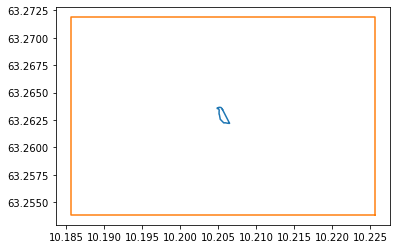

In [63]:
from src.kornmo.mask.geo_point_translator import GeoPointTranslator
from shapely.geometry import box
from src.utils import boundingBox, convert_crs
import matplotlib.pyplot as plt

bbox = boundingBox(poly.centroid.y, poly.centroid.x, 1)
bbox_new = box(bbox[0], bbox[1], bbox[2], bbox[3])

plt.plot(*poly.exterior.xy)
plt.plot(*bbox_new.exterior.xy)

point_translator = GeoPointTranslator(bbox_new)

print(point_translator.lat_lng_to_screen_xy(poly))

#print(point_translator.lat_lng_to_screen_xy(poly.centroid.y, poly.centroid.x))

#print(latlngToScreenXY(bbox[1], bbox[0]))
#xy = geo_translator.lat_lng_to_screen_xy(bbox[1], bbox[0])




